In [1132]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import graphviz
import seaborn as sns

from copy import deepcopy

In [1426]:

class Host:
    def __init__(self):
        self.n_nodes = 6
        self.n_signalers = self.n_nodes - 2
        
        self.network = nx.binomial_graph(directed=True, n=self.n_nodes,p=0.5)
        
        mapping = dict(list(zip(range(n_nodes), ['D']+list(range(n_nodes-2))+['E'])))
        
        self.network = nx.relabel_nodes(self.network, mapping)
                
        for i,node in enumerate(self.network.nodes):
            self.network.nodes[node]['active'] = 0.5
            self.network.nodes[node]['label'] = (['D']+(self.n_nodes-2)*['S']+['E'])[i]
    
        for u,v,e in self.network.edges(data=True):
            e['weight'] = np.random.uniform(-1,1)

        self.network.remove_edges_from([('E','D'),('D','E')])
        
        #to track back for reproduction
        self.architecture = self.network
        
        self.infected = False
        
    
    
    def update(self):
        network_copy = deepcopy(self.network)

        for node in self.network.nodes:
            dP = 0
            for n in self.network.predecessors(n=node):
                weight = nx.get_edge_attributes(self.network,'weight')[(n,node)] 
                if weight > 0:
                    dP += (1-self.network.node[node]['active'])*weight*self.network.node[n]['active']
                elif weight < 0:
                    dP += self.network.node[node]['active']*weight*self.network.node[n]['active']
            
            if np.isnan(dP):
                print('NAN!')
                print(nx.get_edge_attributes(self.network,'weight'))
                print(nx.get_node_attributes(self.network,'active'))
            
            if network_copy.node[node]['active'] + dP > 1:
                network_copy.node[node]['active'] = 1
            elif network_copy.node[node]['active'] + dP < 0:
                network_copy.node[node]['active'] = 0
            else:
                network_copy.node[node]['active'] += dP
            
            #network_copy.node[node]['active'] = min(1, network_copy.node[node]['active'] + dP) 

        self.network = network_copy
    
    def infect(self, r=0.8, v=2, verbose=0, seed = np.random.randint(0,1000)):
        self.v = 2
        self.network.add_node(node_for_adding='P', active=0.5, label='P')
        self.network.add_weighted_edges_from([('P','D',1.0), ('E','P',-1.0), ('P','P',r)])
        
        np.random.seed(seed=seed)
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        self.network.nodes['P']['target'] = np.random.choice(signalers)
        
        self.network.nodes['P']['mode'] = np.random.choice(['upreg','downreg'])
        
        self.network.nodes['P']['area'] = 0.5
        self.network.nodes['P']['v'] = 2

        if verbose >= 1:
            print(self.network.nodes['P'])
        
        
        target = self.network.nodes['P']['target']
        
        if self.network.nodes['P']['mode'] == 'downreg':
            self.network.remove_node(target)
        elif self.network.nodes['P']['mode'] == 'upreg':
            self.network.nodes[target]['active'] = 1
            self.network.remove_edges_from([e for e in self.network.edges if e[1] == target])

            for e in [e for e in self.network.edges if e[0] == target]:
                if self.network.edges[e]['weight'] > 0:
                    self.network.edges[e]['weight'] = min(1.0, 2*self.network.edges[e]['weight'])
                else:
                    self.network.edges[e]['weight'] = max(-1.0, 2*self.network.edges[e]['weight'])
    
    def evolve(self, parasite_seed=np.random.randint(0,1000), verbose=0):
        for _ in range(600):
            self.update()
        
        active_pre = self.network.nodes['E']['active']
        self.infect(seed = parasite_seed, verbose = verbose)
        
        for _ in range(600):
            self.update()
            self.network.nodes['P']['area'] += self.network.nodes['P']['active']
        
        active_post = self.network.nodes['E']['active']
        area = round(self.network.nodes['P']['area'] / 600,4)
        v = self.network.nodes['P']['v']
        
        if verbose >= 2:
            print('Active_pre: ', active_pre)
            print('Active_post: ', active_post)
            print('Area: ', area)
        
        self.fitness_host = np.exp(-1*(active_pre + v*area + active_post))
        self.fitness_parasite = np.exp(-1*(2+v)*(1-area))
        
    
    
    def mutate(self, verbose=0):
        """
        25% addition of new allowed edge
        25% deletion of existing edge
        30% alteration of existing edge **
        10% duplication of a protein and all its edges
        10% deletion of a protein and all its edges
        """
        mutation_type = np.random.random()
        
        if mutation_type < 0.25:
            #add allowed edge
            new_architecture = self.new_edge(verbose=verbose)
        
        elif mutation_type < 0.5:
            #remove edge
            new_architecture = self.remove_edge(verbose=verbose)
        
        elif mutation_type < 0.8:
            #alter edge
            new_architecture = self.alter_edge(verbose=verbose)
            
        elif mutation_type < 0.9:
            #duplicate signaler
            new_architecture = self.duplicate_signaler(verbose=verbose) #to do: find out how to increase n_signalers
        else:
            #delete signaler
            new_architecture = self.remove_signaler(verbose=verbose) #to do: find out how to decrease n_signalers
        
        return new_architecture
    
    
    def new_edge(self, verbose=0):
        
        new_architecture = self.architecture
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        edge_already_exists = True
        
        while edge_already_exists:

            node1 = np.random.choice(signalers)
            
            node2 = np.random.choice(new_architecture.nodes)

            potential_edge = sorted((node1,node2), key=lambda k: np.random.random())

            for i,node in enumerate(potential_edge):
                try:
                    potential_edge[i] = int(node)
                except:
                    pass


            if potential_edge[0] == potential_edge[1]:
                continue

            if potential_edge not in new_architecture.edges:
                edge_already_exists = False

        new_weight = np.random.uniform(-1.0,1.0)
        new_architecture.add_weighted_edges_from([(potential_edge[0], potential_edge[1], new_weight)])
        
        if verbose >= 1:
            print('New edge: ', potential_edge,' Weight: ', new_weight)
            
        return new_architecture
    
    def remove_edge(self, verbose=0):
        
        new_architecture = self.architecture
        
        if len(new_architecture.edges()) == 0:
            if verbose >= 1:
                print('Warning: cannot remove more edges')
            return new_architecture
        
        edge_index = np.random.randint(0,len(new_architecture.edges()))
        edge_to_remove = list(new_architecture.edges)[edge_index]

        new_architecture.remove_edge(edge_to_remove[0], edge_to_remove[1])
        
        if verbose >= 1:
            print('Edge to remove: ',edge_to_remove)
        
        return new_architecture

    def alter_edge(self, verbose=0):
        
        new_architecture = self.architecture
        
        try:
            edge_index = np.random.randint(0,len(new_architecture.edges()))
            edge_to_alter = list(new_architecture.edges())[edge_index]
            new_architecture.edges[edge_to_alter]['weight'] = np.random.uniform(-1.0,1.0)

            if verbose >= 1:
                print('New weight of ', edge_to_alter, ': ', new_architecture.edges[edge_to_alter]['weight'])
        except:
            pass
        return new_architecture
    
    
    def duplicate_signaler(self, verbose=0):
        
        new_architecture = self.architecture
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        if len(signalers) >= 8:
            if verbose >= 1:
                print('Warning: cannot add more signalers')
            return new_architecture

        signaler_index = np.random.choice(signalers)
        
        if verbose >= 1:
            print('Signaler to undergo duplication: ', signaler_index)

        new_out_edges =[(max(signalers)+1,v,d['weight']) for u,v,d in new_architecture.edges(data=True) if u == signaler_index]
        new_in_edges = [(u,max(signalers)+1,d['weight']) for u,v,d in new_architecture.edges(data=True) if v == signaler_index]

        new_architecture.add_node(max(signalers)+1)
        new_architecture.add_weighted_edges_from(new_out_edges)
        new_architecture.add_weighted_edges_from(new_in_edges)

        new_architecture.nodes[max(signalers)+1]['label'] = 'S'
        new_architecture.nodes[max(signalers)+1]['active'] = 0.5
        
        return new_architecture
        
    def remove_signaler(self, verbose=0):
        
        new_architecture = self.architecture
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        if len(signalers) <= 1:
            if verbose >= 1:
                print('Warning: cannot remove more signalers')
            return new_architecture
        
        node_to_remove = np.random.choice(signalers)

        if verbose >= 1:
            print('Signaler to remove: ',node_to_remove)
        
        new_architecture.remove_node(node_to_remove)
        
        return new_architecture
        
    def reproduce(self, p_mutation=5e-3, verbose=0):
        if np.random.random() < p_mutation:
            new_architecture = self.mutate(verbose=verbose)
            new_n_signalers = len([n for n in self.architecture.nodes if n not in ['D','E']])
            
            return HostChild(new_architecture, new_n_signalers)
        
        else:
            if verbose >= 1:
                print('No mutations occurred')
            return HostChild(self.architecture, self.n_signalers)
            
        
    def visualize(self):
        edges,weights = zip(*nx.get_edge_attributes(self.network,'weight').items())

        activating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]
        positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]

        deactivating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        
        active_ratios = list(nx.get_node_attributes(self.network,'active').values())
        #print(active_ratios)
        
        pos = nx.shell_layout(self.network)

        graph_nodes = nx.draw_networkx_nodes(self.network, node_size=300, pos=pos, alpha=1, 
                               node_color= [a for a in active_ratios],
                                            cmap='Greens', vmin=0, vmax=1.5)  

        graph_act_edges =nx.draw_networkx_edges(self.network, edgelist=activating,
                               pos=pos, width=[5*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                                alpha=1)

        graph_deact_edges = nx.draw_networkx_edges(self.network, edgelist=deactivating,
                               pos=pos, width=[5*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                                alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))
        
#         if n_nodes == self.network.number_of_nodes():
#             letters = ['D']+(self.n_nodes-2)*['S']+['E'] 
#         else:
#             n_added_signalers = self.network.number_of_nodes() - n_nodes
#             letters = ['D']+(self.n_nodes-2)*['S']+['E'] + n_added_signalers*['S']
            
        labels = nx.get_node_attributes(self.network, 'label')#dict(zip(self.network.nodes,letters))

        nx.draw_networkx_labels(self.network, pos=pos, 
                               labels = labels)
        nx.draw_networkx_edge_labels(self.network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
        nx.draw_networkx_edge_labels(self.network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))
        
        graph_nodes.set_edgecolor('k')

        for e in graph_act_edges+graph_deact_edges:
            e.set_alpha(0.5)

        plt.show()

class HostChild(Host):
    def __init__(self, new_architecture, n_signalers):
        super().__init__()

        self.network = new_architecture
        self.architecture = new_architecture

In [1414]:


# signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
# np.random.choice(signalers)

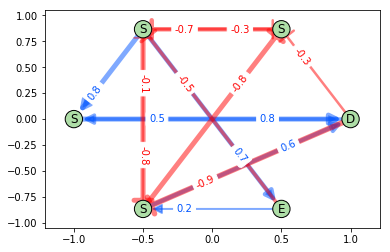

Edge to remove:  (3, 0)
New edge:  [0, 'E']  Weight:  0.7162438140182326
Edge to remove:  (3, 'D')
New weight of  (1, 3) :  -0.7494000091656021
New edge:  [3, 0]  Weight:  -0.34279376611262946
Edge to remove:  ('D', 2)
New weight of  (2, 'D') :  0.30676700054159145
New edge:  [2, 3]  Weight:  -0.2745748185813044
Signaler to undergo duplication:  2
New edge:  [3, 2]  Weight:  0.42653569604243846
Signaler to remove:  4
New edge:  ['E', 2]  Weight:  -0.25848074304145774
Edge to remove:  (1, 0)
No mutations occurred
New weight of  ('E', 3) :  -0.4720384454300848
New edge:  [1, 0]  Weight:  -0.4078484382197458
Edge to remove:  (3, 0)
Edge to remove:  (3, 1)
Edge to remove:  (1, 3)
New weight of  ('E', 3) :  -0.2837134963447785
Signaler to undergo duplication:  0
New edge:  [4, 'D']  Weight:  -0.5198098331064689
New edge:  ['E', 0]  Weight:  0.6585396436611057
No mutations occurred
New edge:  [4, 3]  Weight:  0.5845826929213529
New edge:  ['D', 1]  Weight:  0.8056310471990673
New weight of  

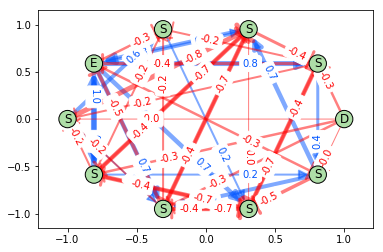

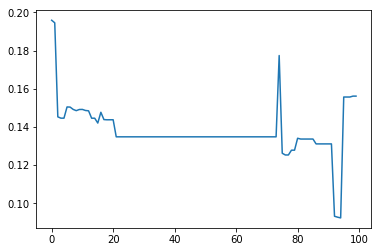

In [1427]:

child = Host()
child.visualize()

fitness_record = []

for _ in range(100):
    child.evolve(parasite_seed=10, verbose=0)
    np.random.seed()
    fitness_record.append(child.fitness_host)
    if child.fitness_host > 1e-4:
        child = child.reproduce(p_mutation=0.9,verbose=1)
        #child.visualize()
    else:
        'The host died without reproducing'

child.visualize()

plt.plot(fitness_record)
plt.show()


# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()




#list(net.network.nodes).remove(['D','E'])




#print([type(d['weight']) for u,v,d in net.network.edges(data=True)])



#np.random.choice(net.network.edges())

# edge_index = np.random.randint(0,len(net.network.edges()))
# edge_to_alter = list(net.network.edges())[edge_index]
# net.network.edges[edge_to_alter]['weight'] = np.random.uniform(-1.0,1.0)

#print('...',edge_to_alter)

#for e in net.network.edges():
#    print(net.network.edges[e])



#print(edge_to_remove)
#net.visualize()


# hfitness = []
# pfitness = []

# for _ in range(40):
#     net = Host()

#     net.evolve(seed=10, verbose=0)
# #    net.visualize()
#     hfitness.append(net.fitness_host)
#     pfitness.append(net.fitness_parasite)
#     if net.fitness_parasite > 1: print(net.fitness_parasite)
    
#     if _ % 10 == 0: print((_+10),'% done')

# sns.distplot(hfitness)
# sns.distplot(pfitness)
# plt.xscale('log')
# plt.show()

# print('CI Host: ', np.percentile(hfitness, [2.5,97.5]))
# print('CI Parasite: ', np.percentile(pfitness, [2.5,97.5]))


    #print(net.fitness_parasite)

# for _ in range(1000):
#     net.update()
# net.visualize()

# net.infect()

# print(net.network.nodes['P'])


# net.visualize()

# for _ in range(100):
#     net.update()
# net.visualize()
# print(net.network.nodes)

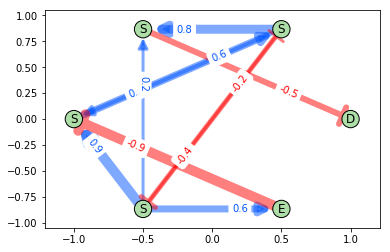

(0.7836720817875342,
 0.30354824786580803,
 -0.38316354575187517,
 -0.46276880384768737,
 0.6085317310864882,
 -0.18043477076739767,
 0.15955452814399318,
 0.8758469587631248,
 0.6486390425279196,
 -0.8594355079729348)

In [1251]:
n_nodes = 6
host_network = nx.binomial_graph(directed=True, n=n_nodes,p=0.5)

#### initialize


for node in host_network.nodes:
    host_network.nodes[node]['active'] = 0.5


for u,v,e in host_network.edges(data=True):
    e['weight'] = np.random.uniform(-1,1)

host_network.remove_edges_from([(0,n_nodes-1),(n_nodes-1,0)])




#### visualize

edges,weights = zip(*nx.get_edge_attributes(host_network,'weight').items())

activating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]
positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]

deactivating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]
negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]

active_ratios = list(nx.get_node_attributes(host_network,'active').values())

pos = nx.shell_layout(host_network)

graph_nodes = nx.draw_networkx_nodes(host_network, node_size=300, pos=pos, alpha=1, 
                       node_color= [a for a in active_ratios],
                                    cmap='Greens', vmin=0, vmax=1.5)  

graph_act_edges =nx.draw_networkx_edges(host_network, edgelist=activating,
                       pos=pos, width=[10*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                        #edge_cmap= plt.cm.Blues, vmax=1, edge_color=positive_weights,
                        alpha=1)

graph_deact_edges = nx.draw_networkx_edges(host_network, edgelist=deactivating,
                       pos=pos, width=[10*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                        #edge_cmap= plt.cm.Reds, edge_color=negative_weights,
                        alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))

letters = ['D']+(host_network.number_of_nodes()-2)*['S']+['E']
labels = dict(zip(host_network.nodes,letters))

nx.draw_networkx_labels(host_network, pos=pos, 
                       labels = labels)
nx.draw_networkx_edge_labels(host_network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
nx.draw_networkx_edge_labels(host_network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))


#ax = plt.gca() # to get the current axis

graph_nodes.set_edgecolor('k')

for e in graph_act_edges+graph_deact_edges:
    e.set_alpha(0.5)

plt.show()

weights

In [1025]:
dict(list(zip(range(n_nodes), ['D']+list(range(n_nodes-2))+['E'])))

{0: 'D', 1: 0, 2: 1, 3: 2, 4: 3, 5: 'E'}

TypeError: Cannot cast array from dtype('float64') to dtype('int64') according to the rule 'safe'

In [1192]:
np.array(['P',2])
#np.random.sample(('P',2))
sorted(('P',2), key=lambda k: np.random.random())

['P', 2]

In [1204]:
net.network.nodes['2']

KeyError: '2'

In [1216]:
int('2')

2

In [1370]:
5e-3

0.005